# COVID19 - Brazil States

# import Ray

In [1]:
from environs import Env
env = Env()
env.str("CUDA_DEVICE_ORDER",'PCI_BUS_ID')
env.int("CUDA_VISIBLE_DEVICES",1)
env.int("NUMBA_ENABLE_CUDASIM",1)
env.bool("OMPI_MCA_opal_cuda_support",True)

import os
import ray
MB=1024*1024
GB=MB*1024
ray.init(object_store_memory=1*GB,memory=1*GB,\
         driver_object_store_memory=500*MB,num_gpus=5,num_cpus=5, 
         ignore_reinit_error=True) # , include_webui=False, ignore_reinit_error=True)

@ray.remote(num_gpus=1)
def use_gpu():
    print("ray.get_gpu_ids(): {}".format(ray.get_gpu_ids()[0]))
    print("CUDA_VISIBLE_DEVICES: {}".format(os.environ["CUDA_VISIBLE_DEVICES"]))

use_gpu.remote()

2020-07-24 15:22:58,287	INFO resource_spec.py:212 -- Starting Ray with 0.98 GiB memory available for workers and up to 1.0 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-07-24 15:22:58,626	INFO services.py:1170 -- View the Ray dashboard at localhost:8266


ObjectID(45b95b1c8bd3a9c4ffffffff010000c801000000)

# Import Modules

In [2]:
import urllib.request
import pandas as pd
import numpy as np
from datetime import datetime,timedelta

# Download data

In [3]:
import get_data
LoadData=True

if LoadData:
    get_data.get_data()

Baixando arquivos brasil.io...
(pid=81271) ray.get_gpu_ids(): 4
(pid=81271) CUDA_VISIBLE_DEVICES: 4


In [4]:
df = pd.read_csv("data/dados_total_estados.csv")
df.drop('index', axis=1, inplace=True)
df['date'] = pd.to_datetime(df['date'],format='%Y-%m-%d') 
df = df[df.date<=datetime.strptime("2020-07-24", '%Y-%m-%d')]
display(df)

date state   city place_type  confirmed  deaths  order_for_place  \
0    2020-07-23    AC  TOTAL      state      18157     474              129   
1    2020-07-22    AC  TOTAL      state      17979     470              128   
2    2020-07-21    AC  TOTAL      state      17700     469              127   
3    2020-07-20    AC  TOTAL      state      17462     465              126   
4    2020-07-19    AC  TOTAL      state      17295     460              125   
...         ...   ...    ...        ...        ...     ...              ...   
3512 2020-02-29    SP  TOTAL      state          2       0                5   
3513 2020-02-28    SP  TOTAL      state          2       0                4   
3514 2020-02-27    SP  TOTAL      state          1       0                3   
3515 2020-02-26    SP  TOTAL      state          1       0                2   
3516 2020-02-25    SP  TOTAL      state          1       0                1   

      is_last      popEst  city_ibge_code  confirmed_per_100k_inhabitants  \
0        True    881935.0            12.0                      2058.76850   
1       False    881935.0            12.0                      2038.58561   
2       False    881935.0            12.0                      2006.95063   
3       False    881935.0            12.0                      1979.96451   
4       False    881935.0            12.0                      1961.02887   
...       ...         ...             ...                             ...   
3512    False  45919049.0            35.0                         0.00436   
3513    False  45919049.0            35.0                         0.00436   
3514    False  45919049.0            35.0                         0.00218   
3515    False  45919049.0            35.0                         0.00218   
3516    False  45919049.0            35.0                         0.00218   

      death_rate  
0         0.0261  
1         0.0261  
2         0.0265  
3         0.0266  
4         0.0266  
...          ...  
3512      0.0000  
3513      0.0000  
3514      0.0000  
3515      0.0000  
3516      0.0000  

[3517 rows x 12 columns]

# Model

# SEAIR-D Model Equations

$$\begin{array}{l}\frac{d s}{d t}=-[\beta i(t) + \beta_2 a(t)-\mu] \cdot s(t)\\ 
\frac{d e}{d t}=[\beta i(t) + \beta_2 a(t)] \cdot s(t) -(\sigma+\mu) \cdot e(t)\\ 
\frac{d a}{d t}=\sigma e(t) \cdot (1-p)-(\gamma_2+\mu) \cdot a(t) \\
\frac{d i}{d t}=\sigma e(t) \cdot p - (\gamma + \sigma_2 + \sigma_3 + \mu) \cdot i(t)\\ 
\frac{d r}{d t}=(b + \sigma_2) \cdot i(t) + d \cdot a(t) - \mu \cdot r(t)\\
\frac{d k}{d t}=(a + \sigma_3) \cdot i(t) + c \cdot a(t) + \mu \cdot k(t)
\end{array}$$

$$\gamma = a + b$$

$$\gamma_2 = c + d$$

$$p=0.2$$

The last equation does not need to be solve because:

$$s + e + i + a + r + k = N$$ 

$N$ is the total population of the region, state or country. If you derivate and by considering population constant during the period of simulation, you get the equation of $k$ without depending of the $N$.

$$\frac{d k}{d t}=-(\frac{d e}{d t}+\frac{d a}{d t}+\frac{d i}{d t}+\frac{d r}{d t})$$

The sum of all rates are equal to zero! The importance of this equation is that it conservates the rates.

## Parameters

$\beta$: Effective contact rate [1/min]
    
$\gamma$: from infected Recovery(+Mortality) rate $\gamma=(a+b)$ [1/min]

$\gamma_2$: from assymptomatic Recovery(+Mortality) rate $\gamma=(a+b)$ [1/min]

$a$: mortality of healed from infected  [1/min]

$b$: recovery rate from infected [1/min]

$c$: mortality of healed from assymptomatic [1/min]

$d$: recovery rate from assymptomatic [1/min]

$\sigma$: is the rate at which individuals move from the exposed to the infectious classes. Its reciprocal ($1/\sigma$) is the average latent (exposed) period.

$\sigma_2$: is the rate at which individuals move from the infectious to the healed classes. Its reciprocal ($1/\sigma_2$) is the average latent (exposed) period

$\sigma_3$: is the rate at which individuals move from the infectious to the dead classes. Its reciprocal ($1/\sigma_3$) is the average latent (exposed) period
    
$p$: is the fraction of the exposed which become symptomatic infectious sub-population.

$(1-p)$: is the fraction of the exposed which becomes asymptomatic infectious sub-population.

# Initial parameters

In [5]:
paramOpt=4
changeCSV=False
adjustParam=True
paramSave=False
selectStates=False

## Select Parameters File, Version and Model

In [6]:
if paramOpt==0:
    paramFile="data/param.csv"
    version = "1"
    model = "ManualIC"

if paramOpt==1:
    paramFile="data/param_optimized_DE_Scipy.csv"    
    version = "1002"
    model = "DE_ScipyIC"
    
if paramOpt==2:
    paramFile="data/param_optimized_DE_SciPy_HistMin.csv"
    version = "1002"
    model = "DE_ScipyIC"

if paramOpt==3:
    paramFile="data/param_optimized_Yabox.csv"    
    version = "103"
    model = "YaboxIC"
    
if paramOpt==4:
    paramFile="data/param_optimized_Yabox_HistMin.csv"
    version = "105"
    model = "YaboxIC"

if paramOpt==5:
    paramFile="data/param_optimized_Brute_Force.csv"
    version = "12"
    model = "BruteForceIC"

if paramOpt==6:
    paramFile="data/param_optimized_Brute_Force_HistMin.csv"
    version = "12"
    model = "BruteForceIC"

## Final Adjust in Parameters

In [7]:
dfparam = pd.read_csv(paramFile)
dfparam = dfparam.dropna()

if selectStates:
    states=['SP','MG','AM','PE','ES','RJ']
else:
    states=dfparam.state

if changeCSV:
    dfparam.loc[dfparam.state=='PI','d0'] = 0
    dfparam.loc[dfparam.state=='RR','d0'] = 0
    dfparam.loc[dfparam.state=='AP','d0'] = 0
    dfparam.loc[dfparam.state=='SP','WCASES'] = 0.65

if paramSave:
    dfparam.to_csv(paramFile)    
    
if adjustParam:
    sCorrect=[0.85,1.25,1.0,1.25,1.5,0.95,1.25,1.15,1.11,0.85,0.9]
    #103 [1.25,1.3,1.3,1.3,1.3,1.3,1.3,1.3,1.0,1.0,1.1]
    dfparam.s0=dfparam.s0.multiply(sCorrect[:len(states)], axis=0)

dfparam

state  start-date  prediction-range           s0  e0  a0    i0   r0   d0  \
0     SP  2020-03-15               200  11425444.15   0   0  1419  300   14   
1     ES  2020-04-08               200    640370.00   0   0    52  250   88   
2     MG  2020-03-30               200   1795035.00   0   0   412  250    4   
3     RJ  2020-03-12               200   1243865.00   0   0   820  250    1   
4     CE  2020-03-20               200   1471506.00   0   0  1152  250   16   
5     PE  2020-03-19               200   1139370.15   0   0  1265  250   98   
6     AM  2020-03-24               200   1473115.00   0   0   922  250   53   
7     PA  2020-03-24               200   1302421.00   0   0  1234  250  116   
8     PI  2020-03-24               200   1068113.04   0   0  1549  250   30   
9     RR  2020-03-19               200    943445.60   0   0  1029  250    6   
10    AP  2020-03-14               200    605606.40   0   0  1303  250    3   

    START  RATIO  WCASES    WREC  
0       0   0.15  0.5758  0.0228  
1       1   0.15  0.7422  0.0432  
2       2   0.15  0.3731  0.0303  
3      35   0.15  0.6334  0.0339  
4       8   0.15  0.5564  0.0714  
5     116   0.15  0.7431  0.0459  
6      24   0.15  0.4114  0.0773  
7      66   0.15  0.7340  0.0497  
8      31   0.15  0.4410  0.0339  
9       2   0.15  0.5061  0.0229  
10     31   0.15  0.5386  0.0605

# Define States Array and Import Solver

In [8]:
# Load solver
%reload_ext autoreload
%autoreload 2
import LearnerYabox_v2b as Learner #Yabox

## Activate Scrolling

In [9]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines){
    return true;}

<IPython.core.display.Javascript object>

## Select the Running Type

In [10]:
allStates=True
cleanRecovered=False
version="8"

display(states)

0     SP
1     ES
2     MG
3     RJ
4     CE
5     PE
6     AM
7     PA
8     PI
9     RR
10    AP
Name: state, dtype: object

## Main Loop

In [11]:
results=[]
if allStates:
    for state in states:        
        query = dfparam.query('state == "{}"'.format(state)).reset_index()
        parameters = np.array(query.iloc[:, 2:])[0]
        f=Learner.Learner.remote(state, *parameters, cleanRecovered, version)
        result = f.train.remote() 
        results.append(result)
else:
    state= "RJ"
    query = dfparam.query('state == "{}"'.format(state)).reset_index()
    parameters = np.array(query.iloc[:, 2:])[0]
    parameters
    cleanRecovered = False
    f=Learner.Learner.remote(state, *parameters, cleanRecovered, version)
    result = f.train.remote() 
    results.append(result)

# #execute all the queue with max_runner_cap at a time    
results = ray.get(results)

2020-07-24 15:23:13,289	WARNING worker.py:1090 -- WARNING: 15 PYTHON workers have been started. This could be a result of using a large number of actors, or it could be a consequence of using nested tasks (see https://github.com/ray-project/ray/issues/3644) for some a discussion of workarounds.


  0%|          | 91/6125000 [00:16<213:39:37,  7.96it/s]


  0%|          | 253/6125000 [00:31<115:42:41, 14.70it/s]


  0%|          | 703/6125000 [00:45<55:05:52, 30.88it/s]


  0%|          | 1378/6125000 [00:57<30:28:00, 55.83it/s]


  0%|          | 2080/6125000 [01:08<23:10:17, 73.40it/s]


  0%|          | 1891/6125000 [01:11<25:16:09, 67.31it/s]
(pid=81360) /home/ats4i/anaconda3/envs/geo_env/lib/python3.6/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
(pid=81360)   warnings.warn(warning_msg, ODEintWarning)
  0%|          | 2211/6125000 [01:18<22:29:50, 75.60it/s]


  0%|          | 2850/6125000 [01:26<19:18:00, 88.11it/s]
(pid=81364) /home/ats4i/anaconda3/envs/geo_env/lib/python3.6/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
(pid=81364)   warnings.warn(warning_msg, ODEintWarning)
  0%|          | 4851/6125000 [01:27<12:21:38, 137.54it/s]


  0%|          | 4005/6125000 [01:38<16:31:57, 102.84it/s]


  0%|          | 6903/6125000 [01:47<11:26:34, 148.52it/s]


  0%|          | 6328/6125000 [01:57<13:11:53, 128.78it/s]


  0%|          | 11781/6125000 [02:06<7:54:31, 214.71it/s]


  0%|          | 10296/6125000 [02:08<9:00:59, 188.38it/s]/home/ats4i/anaconda3/envs/geo_env/lib/python3.6/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
(pid=81273)   warnings.warn(warning_msg, ODEintWarning)
  0%|          | 11781/6125000 [02:16<8:40:18, 195.82it/s]


  0%|          | 13366/6125000 [02:27<7:51:42, 215.94it/s]


  0%|          | 14535/6125000 [02:37<8:16:11, 205.24it/s]


  0%|          | 14535/6125000 [02:47<8:31:33, 199.08it/s]


  0%|          | 20301/6125000 [02:57<6:34:31, 257.89it/s]


  0%|          | 24090/6125000 [03:06<5:42:43, 296.68it/s]


  1%|          | 31375/6125000 [03:15<4:45:40, 355.51it/s]


  0%|          | 28680/6125000 [03:26<5:22:57, 314.60it/s]


  1%|          | 33411/6125000 [03:35<4:54:18, 344.97it/s]


  1%|          | 42486/6125000 [03:44<4:08:33, 407.86it/s]


  1%|          | 37675/6125000 [03:54<5:07:33, 329.88it/s]


  1%|          | 43365/6125000 [04:03<4:18:25, 392.23it/s]


  1%|          | 44850/6125000 [04:13<4:16:55, 394.41it/s]


  1%|          | 59685/6125000 [04:22<3:29:13, 483.16it/s]


  1%|          | 61425/6125000 [04:32<3:17:56, 510.56it/s]


  1%|          | 44253/6125000 [04:34<4:45:04, 355.50it/s]
(pid=81271) /home/ats4i/anaconda3/envs/geo_env/lib/python3.6/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
(pid=81271)   warnings.warn(warning_msg, ODEintWarning)
  1%|          | 56953/6125000 [04:41<3:44:00, 451.46it/s]


  1%|          | 74305/6125000 [04:50<3:01:46, 554.77it/s]


  1%|          | 67528/6125000 [05:00<3:25:39, 490.91it/s]


  1%|          | 74691/6125000 [05:09<3:10:15, 530.02it/s]


  1%|▏         | 90951/6125000 [05:17<2:37:11, 639.77it/s]


  2%|▏         | 97461/6125000 [05:28<2:28:08, 678.15it/s]


  1%|▏         | 85078/6125000 [05:36<3:02:23, 551.91it/s]


  1%|▏         | 90525/6125000 [05:46<2:51:47, 585.45it/s]


  2%|▏         | 95266/6125000 [05:56<2:57:13, 567.06it/s]


  2%|▏         | 121278/6125000 [06:05<2:21:08, 708.92it/s]


  2%|▏         | 112575/6125000 [06:14<2:33:01, 654.81it/s]


  2%|▏         | 129286/6125000 [06:23<2:11:44, 758.50it/s]


  2%|▏         | 118341/6125000 [06:32<2:33:31, 652.11it/s]


  2%|▏         | 130816/6125000 [06:41<2:25:18, 687.51it/s]


  2%|▏         | 140185/6125000 [06:50<2:14:33, 741.25it/s]


  3%|▎         | 157641/6125000 [06:59<2:03:43, 803.87it/s]


  2%|▏         | 149331/6125000 [07:08<2:02:19, 814.22it/s]


  2%|▏         | 149878/6125000 [07:17<2:16:45, 728.19it/s]


  3%|▎         | 156520/6125000 [07:26<2:12:13, 752.27it/s]


  3%|▎         | 174936/6125000 [07:35<1:58:54, 833.98it/s]


  3%|▎         | 182710/6125000 [07:44<1:53:19, 873.95it/s]


  3%|▎         | 179700/6125000 [07:53<1:54:58, 861.77it/s]


  3%|▎         | 187578/6125000 [08:02<1:47:28, 920.76it/s]


  3%|▎         | 201930/6125000 [08:11<1:59:27, 826.37it/s]


  3%|▎         | 188191/6125000 [08:20<1:59:56, 824.98it/s]


  4%|▎         | 223446/6125000 [08:29<1:41:17, 971.06it/s]


  4%|▍         | 248160/6125000 [08:37<1:36:30, 1015.00it/s]


  5%|▍         | 278631/6125000 [08:47<1:15:27, 1291.16it/s]


  4%|▍         | 242556/6125000 [08:55<1:40:56, 971.29it/s]


  5%|▍         | 280875/6125000 [09:05<1:31:42, 1061.99it/s]


  4%|▍         | 261726/6125000 [09:14<1:37:23, 1003.46it/s]


  5%|▍         | 301476/6125000 [09:23<1:26:38, 1120.31it/s]


  5%|▍         | 280126/6125000 [09:32<1:32:53, 1048.69it/s]


  5%|▌         | 321201/6125000 [09:40<1:21:47, 1182.63it/s]


  5%|▍         | 298378/6125000 [09:49<1:28:08, 1101.65it/s]


  6%|▌         | 341551/6125000 [09:57<1:16:44, 1256.13it/s]


  6%|▌         | 351541/6125000 [10:05<1:16:27, 1258.41it/s]


  5%|▌         | 336610/6125000 [10:14<1:16:08, 1266.89it/s]


  6%|▌         | 347361/6125000 [10:22<1:14:09, 1298.51it/s]


  6%|▋         | 383250/6125000 [10:29<1:12:02, 1328.35it/s]


  6%|▋         | 383250/6125000 [10:37<1:11:51, 1331.80it/s]


  8%|▊         | 491536/6125000 [10:46<43:34, 2154.91it/s]


  6%|▌         | 376278/6125000 [10:53<1:02:52, 1523.65it/s]


  6%|▌         | 378015/6125000 [10:56<1:16:27, 1252.85it/s]
(pid=81272) /home/ats4i/anaconda3/envs/geo_env/lib/python3.6/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
(pid=81272)   warnings.warn(warning_msg, ODEintWarning)
  7%|▋         | 425503/6125000 [11:00<1:07:45, 1402.01it/s]


  6%|▋         | 385003/6125000 [11:08<1:16:28, 1251.03it/s]


  7%|▋         | 446985/6125000 [11:14<45:17, 2089.61it/s]
(pid=81274) /home/ats4i/anaconda3/envs/geo_env/lib/python3.6/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
(pid=81274)   warnings.warn(warning_msg, ODEintWarning)
  7%|▋         | 446985/6125000 [11:16<1:06:27, 1424.03it/s]


  8%|▊         | 466095/6125000 [11:24<44:02, 2141.82it/s]


  7%|▋         | 425503/6125000 [11:32<1:10:43, 1343.16it/s]


  8%|▊         | 467061/6125000 [11:39<1:05:29, 1440.02it/s]


  8%|▊         | 491536/6125000 [11:46<1:02:34, 1500.49it/s]


  7%|▋         | 423660/6125000 [11:54<1:18:02, 1217.61it/s]


  8%|▊         | 514605/6125000 [12:02<1:02:28, 1496.51it/s]


  9%|▊         | 527878/6125000 [12:11<40:59, 2275.63it/s]


  8%|▊         | 491536/6125000 [12:19<1:05:37, 1430.83it/s]


  9%|▉         | 550725/6125000 [12:28<46:19, 2005.74it/s]


  9%|▉         | 570846/6125000 [12:36<34:04, 2716.62it/s]


 10%|▉         | 591328/6125000 [12:43<32:31, 2835.44it/s]


 11%|█         | 668746/6125000 [12:50<34:10, 2660.89it/s]


 13%|█▎        | 814726/6125000 [12:57<28:57, 3056.42it/s]


  9%|▉         | 553878/6125000 [13:04<58:09, 1596.52it/s]


  8%|▊         | 495510/6125000 [13:11<1:08:26, 1370.89it/s]


 11%|█▏        | 692076/6125000 [13:18<32:10, 2813.59it/s]


 10%|█         | 641278/6125000 [13:25<52:59, 1724.67it/s]


 13%|█▎        | 798216/6125000 [13:32<25:57, 3419.72it/s]


  9%|▊         | 533028/6125000 [13:39<1:07:25, 1382.13it/s]


 10%|█         | 623286/6125000 [13:45<53:27, 1715.11it/s]


 13%|█▎        | 814726/6125000 [13:53<23:07, 3827.26it/s]


 11%|█         | 646953/6125000 [13:59<52:26, 1740.82it/s]


 15%|█▍        | 918690/6125000 [14:06<23:15, 3731.26it/s]


  9%|▉         | 581581/6125000 [14:13<1:02:29, 1478.36it/s]


 15%|█▍        | 917335/6125000 [14:20<21:31, 4031.31it/s]


 12%|█▏        | 738720/6125000 [14:26<47:06, 1905.68it/s]


 18%|█▊        | 1131760/6125000 [14:33<22:01, 3778.76it/s]


 17%|█▋        | 1034641/6125000 [14:35<20:18, 4179.11it/s]
(pid=81270) /home/ats4i/anaconda3/envs/geo_env/lib/python3.6/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
(pid=81270)   warnings.warn(warning_msg, ODEintWarning)
 13%|█▎        | 774390/6125000 [14:38<46:30, 1917.36it/s]


 11%|█         | 687378/6125000 [14:45<57:07, 1586.39it/s]


 20%|█▉        | 1206681/6125000 [14:52<21:12, 3865.78it/s]


 17%|█▋        | 1051975/6125000 [14:59<20:07, 4201.59it/s]


 21%|██        | 1260078/6125000 [15:05<19:36, 4134.16it/s]


 11%|█▏        | 702705/6125000 [15:11<56:04, 1611.59it/s]


 14%|█▍        | 853471/6125000 [15:18<42:05, 2086.95it/s]


 20%|█▉        | 1197378/6125000 [15:28<30:28, 2694.16it/s]


 20%|██        | 1228528/6125000 [15:34<16:56, 4817.31it/s]


 14%|█▍        | 883785/6125000 [15:41<40:49, 2140.12it/s]


 12%|█▏        | 753378/6125000 [15:47<56:13, 1592.43it/s]


 12%|█▏        | 764466/6125000 [15:53<52:41, 1695.38it/s]


 10%|█         | 633375/6125000 [16:01<1:21:08, 1127.94it/s]


 23%|██▎       | 1433971/6125000 [16:07<15:19, 5101.28it/s]


 23%|██▎       | 1417086/6125000 [16:14<16:43, 4693.12it/s]


 26%|██▌       | 1563796/6125000 [16:21<15:35, 4874.81it/s]


 24%|██▎       | 1445850/6125000 [16:27<15:04, 5176.03it/s]


 25%|██▌       | 1558495/6125000 [16:33<14:03, 5415.77it/s]


 14%|█▍        | 871860/6125000 [16:39<47:21, 1848.56it/s]


 27%|██▋       | 1624503/6125000 [16:45<13:49, 5423.28it/s]


 26%|██▌       | 1576200/6125000 [16:51<13:56, 5439.46it/s]


 17%|█▋        | 1065070/6125000 [16:56<31:23, 2685.89it/s]


 18%|█▊        | 1103355/6125000 [17:02<22:23, 3738.89it/s]


 29%|██▊       | 1753128/6125000 [17:08<12:53, 5649.65it/s]


 29%|██▊       | 1751256/6125000 [17:15<13:07, 5551.02it/s]


 30%|██▉       | 1817371/6125000 [17:20<12:44, 5638.06it/s]


 30%|███       | 1849926/6125000 [17:26<12:53, 5530.44it/s]


 31%|███       | 1882770/6125000 [17:31<12:22, 5714.52it/s]


 30%|███       | 1840321/6125000 [17:38<11:58, 5965.01it/s]


 32%|███▏      | 1947351/6125000 [17:43<11:55, 5839.94it/s]


 21%|██        | 1288815/6125000 [17:48<19:44, 4084.45it/s]


 21%|██        | 1256905/6125000 [17:53<17:45, 4569.64it/s]


 21%|██        | 1280800/6125000 [17:59<17:52, 4517.76it/s]


 34%|███▍      | 2075703/6125000 [18:05<11:45, 5739.11it/s]


 22%|██▏       | 1330896/6125000 [18:10<17:27, 4576.97it/s]


 23%|██▎       | 1412040/6125000 [18:17<18:11, 4315.99it/s]


 34%|███▍      | 2087946/6125000 [18:25<10:47, 6230.39it/s]


 23%|██▎       | 1396956/6125000 [18:30<18:02, 4369.27it/s]


 37%|███▋      | 2246140/6125000 [18:37<11:02, 5858.48it/s]


 37%|███▋      | 2263128/6125000 [18:43<10:32, 6105.33it/s]


 18%|█▊        | 1098903/6125000 [18:48<38:47, 2159.50it/s]


 25%|██▍       | 1509453/6125000 [18:53<15:28, 4971.44it/s]


 25%|██▌       | 1537381/6125000 [18:59<15:25, 4959.16it/s]


 18%|█▊        | 1122751/6125000 [19:05<38:30, 2165.20it/s]


 26%|██▌       | 1563796/6125000 [19:11<16:03, 4734.28it/s]


 26%|██▋       | 1622701/6125000 [19:16<14:53, 5037.96it/s]


 27%|██▋       | 1649836/6125000 [19:21<14:52, 5012.25it/s]


 41%|████      | 2492028/6125000 [19:28<09:13, 6558.74it/s]


 42%|████▏     | 2573046/6125000 [19:33<09:55, 5962.23it/s]


 28%|██▊       | 1699246/6125000 [19:38<15:14, 4839.49it/s]


 43%|████▎     | 2641551/6125000 [19:44<08:59, 6462.02it/s]


 29%|██▉       | 1785105/6125000 [19:48<14:18, 5056.24it/s]


 31%|███       | 1886653/6125000 [19:54<12:19, 5728.90it/s]


 45%|████▍     | 2753031/6125000 [19:59<08:25, 6671.80it/s]


 45%|████▍     | 2748340/6125000 [20:05<07:42, 7299.79it/s]


 31%|███       | 1896378/6125000 [20:10<13:12, 5333.75it/s]


 31%|███       | 1894431/6125000 [20:15<13:04, 5395.46it/s]


 47%|████▋     | 2898028/6125000 [20:20<07:59, 6724.39it/s]


 22%|██▏       | 1350546/6125000 [20:26<31:24, 2533.85it/s]


 48%|████▊     | 2968266/6125000 [20:31<07:22, 7138.93it/s]


 33%|███▎      | 2041210/6125000 [20:36<12:10, 5586.74it/s]


 50%|████▉     | 3044278/6125000 [20:41<07:12, 7129.39it/s]


 36%|███▌      | 2203950/6125000 [20:47<10:30, 6219.93it/s]


 35%|███▍      | 2133145/6125000 [20:52<11:22, 5846.10it/s]


 51%|█████     | 3133756/6125000 [20:58<06:47, 7332.67it/s]


 52%|█████▏    | 3171421/6125000 [21:04<06:51, 7183.94it/s]


 53%|█████▎    | 3232153/6125000 [21:09<07:04, 6812.13it/s]


 53%|█████▎    | 3275520/6125000 [21:15<06:57, 6831.87it/s]


 37%|███▋      | 2278045/6125000 [21:22<10:36, 6041.59it/s]


 54%|█████▍    | 3321753/6125000 [21:28<08:48, 5305.06it/s]


 38%|███▊      | 2312325/6125000 [21:34<31:24, 2023.70it/s]


 38%|███▊      | 2344695/6125000 [21:40<10:26, 6036.65it/s]


 39%|███▉      | 2375110/6125000 [21:45<10:32, 5926.76it/s]


 57%|█████▋    | 3483480/6125000 [21:50<05:56, 7400.94it/s]


 26%|██▌       | 1577976/6125000 [21:55<1:24:26, 897.52it/s]


 58%|█████▊    | 3568456/6125000 [22:01<05:27, 7810.25it/s]


 59%|█████▉    | 3608641/6125000 [22:07<05:10, 8106.84it/s]


 26%|██▌       | 1595791/6125000 [22:11<24:31, 3077.38it/s]


 62%|██████▏   | 3774378/6125000 [22:17<05:25, 7212.40it/s]


 61%|██████    | 3738745/6125000 [22:22<04:45, 8363.53it/s]


 44%|████▎     | 2676141/6125000 [22:26<09:02, 6353.47it/s]


 27%|██▋       | 1671706/6125000 [22:31<18:22, 4040.72it/s]


 28%|██▊       | 1693720/6125000 [22:36<16:35, 4451.54it/s]


 63%|██████▎   | 3882291/6125000 [22:42<04:42, 7936.00it/s]


 46%|████▌     | 2809635/6125000 [22:46<08:12, 6737.45it/s]


 46%|████▌     | 2809635/6125000 [22:51<07:42, 7165.19it/s]


 65%|██████▌   | 3994551/6125000 [22:56<04:22, 8115.30it/s]


 30%|██▉       | 1823095/6125000 [23:00<15:28, 4631.14it/s]


 48%|████▊     | 2939100/6125000 [23:05<07:48, 6797.89it/s]


 51%|█████▏    | 3153816/6125000 [23:10<06:06, 8104.78it/s]


 31%|███       | 1871145/6125000 [23:14<14:08, 5013.76it/s]


 31%|███       | 1894431/6125000 [23:19<14:02, 5022.23it/s]


 32%|███▏      | 1941435/6125000 [23:24<12:38, 5518.22it/s]


 32%|███▏      | 1945378/6125000 [23:28<11:48, 5897.57it/s]


 51%|█████     | 3131253/6125000 [23:32<07:04, 7045.05it/s]


 52%|█████▏    | 3163870/6125000 [23:37<06:58, 7081.31it/s]


 72%|███████▏  | 4382280/6125000 [23:42<03:23, 8548.87it/s]


 72%|███████▏  | 4423825/6125000 [23:46<03:24, 8331.69it/s]


 34%|███▍      | 2092035/6125000 [23:51<11:42, 5742.60it/s]


 75%|███████▍  | 4579851/6125000 [23:56<02:48, 9184.40it/s]


 35%|███▍      | 2131080/6125000 [24:01<11:07, 5979.01it/s]


 35%|███▌      | 2162160/6125000 [24:06<10:48, 6113.14it/s]


 36%|███▌      | 2206050/6125000 [24:11<11:30, 5672.69it/s]


 78%|███████▊  | 4781778/6125000 [24:16<02:31, 8867.98it/s]


 57%|█████▋    | 3517878/6125000 [24:20<04:54, 8842.38it/s]


 62%|██████▏   | 3801903/6125000 [24:27<04:23, 8823.30it/s]


 78%|███████▊  | 4757070/6125000 [24:32<02:37, 8676.38it/s]


 59%|█████▊    | 3597903/6125000 [24:37<04:52, 8638.88it/s]


 79%|███████▉  | 4850055/6125000 [24:42<02:15, 9394.15it/s]


 80%|███████▉  | 4884375/6125000 [24:46<02:12, 9328.79it/s]


 80%|████████  | 4928230/6125000 [24:51<02:21, 8477.30it/s]


 41%|████      | 2492028/6125000 [24:56<08:42, 6946.57it/s]


 82%|████████▏ | 5029206/6125000 [25:02<01:58, 9244.12it/s]


 67%|██████▋   | 4094091/6125000 [25:06<03:32, 9565.11it/s]


 64%|██████▎   | 3893445/6125000 [25:11<04:21, 8537.19it/s]


 68%|██████▊   | 4189065/6125000 [25:16<03:14, 9936.76it/s] 


 65%|██████▍   | 3980431/6125000 [25:20<03:58, 8997.64it/s]


 85%|████████▌ | 5230995/6125000 [25:25<01:40, 8896.97it/s]


 71%|███████   | 4326211/6125000 [25:30<03:03, 9804.85it/s]


 87%|████████▋ | 5315430/6125000 [25:34<01:24, 9617.93it/s]


 90%|████████▉ | 5483016/6125000 [25:39<01:09, 9292.86it/s]


 88%|████████▊ | 5400541/6125000 [25:43<01:17, 9292.25it/s]


 89%|████████▉ | 5443350/6125000 [25:47<01:12, 9361.76it/s]


 91%|█████████▏| 5602878/6125000 [25:53<00:54, 9662.25it/s]


 47%|████▋     | 2874003/6125000 [25:57<07:23, 7327.61it/s]


 69%|██████▊   | 4200651/6125000 [26:01<03:56, 8148.28it/s]


 94%|█████████▎| 5737578/6125000 [26:06<00:39, 9909.55it/s]


 70%|██████▉   | 4273426/6125000 [26:10<03:44, 8247.88it/s]


 78%|███████▊  | 4766328/6125000 [26:15<02:25, 9326.90it/s]


 50%|████▉     | 3041811/6125000 [26:19<06:36, 7781.37it/s]


 49%|████▉     | 3009831/6125000 [26:23<07:07, 7285.94it/s]


 51%|█████     | 3108771/6125000 [26:28<06:34, 7648.87it/s]


 96%|█████████▌| 5867025/6125000 [26:32<00:25, 10015.41it/s]


 52%|█████▏    | 3176460/6125000 [26:36<06:11, 7933.40it/s]


 52%|█████▏    | 3211845/6125000 [26:41<06:13, 7794.80it/s]


 52%|█████▏    | 3173940/6125000 [26:46<06:51, 7171.81it/s]


 79%|███████▉  | 4865640/6125000 [26:51<01:55, 10929.77it/s]


 81%|████████  | 4934511/6125000 [26:58<01:52, 10607.71it/s]


 54%|█████▍    | 3316600/6125000 [27:05<06:06, 7663.06it/s]


 87%|████████▋ | 5348085/6125000 [27:12<01:09, 11114.19it/s]


 78%|███████▊  | 4766328/6125000 [27:18<02:33, 8830.13it/s]


 57%|█████▋    | 3496690/6125000 [27:27<05:20, 8208.91it/s]


 58%|█████▊    | 3544453/6125000 [27:34<05:30, 7803.85it/s]


 61%|██████    | 3722356/6125000 [27:42<04:43, 8463.39it/s]


 62%|██████▏   | 3782625/6125000 [27:49<04:31, 8627.89it/s]


 83%|████████▎ | 5105610/6125000 [27:57<01:54, 8930.92it/s]


 63%|██████▎   | 3843378/6125000 [28:05<18:40, 2036.43it/s]


 86%|████████▌ | 5243941/6125000 [28:12<01:37, 9069.15it/s]


 63%|██████▎   | 3868371/6125000 [28:20<04:42, 7995.56it/s]


 66%|██████▌   | 4034220/6125000 [28:26<03:48, 9150.32it/s]


 89%|████████▉ | 5440051/6125000 [28:33<01:13, 9292.03it/s]


 68%|██████▊   | 4174605/6125000 [28:41<03:25, 9505.17it/s]


 69%|██████▉   | 4247155/6125000 [28:49<03:19, 9420.58it/s]


 93%|█████████▎| 5680135/6125000 [28:58<00:46, 9597.93it/s]


 72%|███████▏  | 4438710/6125000 [29:09<02:54, 9666.33it/s]


 96%|█████████▌| 5870451/6125000 [29:18<00:25, 9879.18it/s]


 74%|███████▎  | 4516515/6125000 [29:28<02:39, 10054.03it/s]


 77%|███████▋  | 4710915/6125000 [29:37<02:22, 9944.99it/s] 


 79%|███████▊  | 4822065/6125000 [29:48<02:05, 10385.74it/s]


 41%|████      | 2518890/6125000 [29:59<12:17, 4889.07it/s]


 42%|████▏     | 2577585/6125000 [30:10<11:33, 5117.15it/s]


 43%|████▎     | 2641551/6125000 [30:21<10:46, 5390.40it/s]


 83%|████████▎ | 5073705/6125000 [30:32<01:51, 9450.47it/s]


 46%|████▌     | 2788341/6125000 [30:46<09:06, 6103.30it/s]


 89%|████████▉ | 5466471/6125000 [31:00<01:11, 9157.79it/s]


 88%|████████▊ | 5377560/6125000 [31:14<01:17, 9684.10it/s]


 93%|█████████▎| 5686878/6125000 [31:26<00:37, 11532.84it/s]


 96%|█████████▌| 5853331/6125000 [31:36<00:24, 10917.18it/s]


 93%|█████████▎| 5720653/6125000 [31:49<00:39, 10207.81it/s]


100%|█████████▉| 6098778/6125000 [32:03<00:02, 10843.25it/s]


 55%|█████▍    | 3365715/6125000 [32:26<06:27, 7113.32it/s]


 60%|█████▉    | 3673405/6125000 [33:14<05:53, 6943.16it/s]


 66%|██████▌   | 4054128/6125000 [34:07<04:33, 7566.12it/s]


 73%|███████▎  | 4453620/6125000 [35:10<03:32, 7875.87it/s]


 80%|███████▉  | 4871881/6125000 [36:01<02:20, 8903.82it/s]


 87%|████████▋ | 5308911/6125000 [36:52<01:31, 8903.09it/s]


 94%|█████████▍| 5764710/6125000 [37:54<00:41, 8644.46it/s]


100%|█████████▉| 6123250/6125000 [38:32<00:00, 9184.26it/s]


In [12]:
ray.shutdown()

100%|█████████▉| 6123250/6125000 [38:32<00:00, 2647.74it/s]


# Plots

In [18]:
%matplotlib inline 
import matplotlib.pyplot as plt
import pandas as pd
#%load_ext autoreload
%reload_ext autoreload
%autoreload 2
import covid_plots

In [19]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines){
    return false;}

<IPython.core.display.Javascript object>

In [20]:
#select states for plotting log plot
states4Plot=['MG',
               'ES',
               'SP',
               'CE',
               'RJ']

#Choose here your options
#opt=0 all plots
#opt=1 corona log plot
#opt=2 logistic model prediction
#opt=3 bar plot with growth rate
#opt=4 log plot + bar plot
#opt=5 SEAIR-D Model
opt = 5

#number of cases to start plotting model in log graph - real data = 100
startCase=100

In [21]:
#plots one district or all districts
plotStates=True

#select states for plotting
#you need to run (solve) it before plotting
if plotStates:
    states=dfparam.state
    allStates=True

#main state for plotting log graph or SEAIRD plot
state="SP"

#if it is not SEAIRD plot, so plot one state only
if not opt==5:
    allStates=False

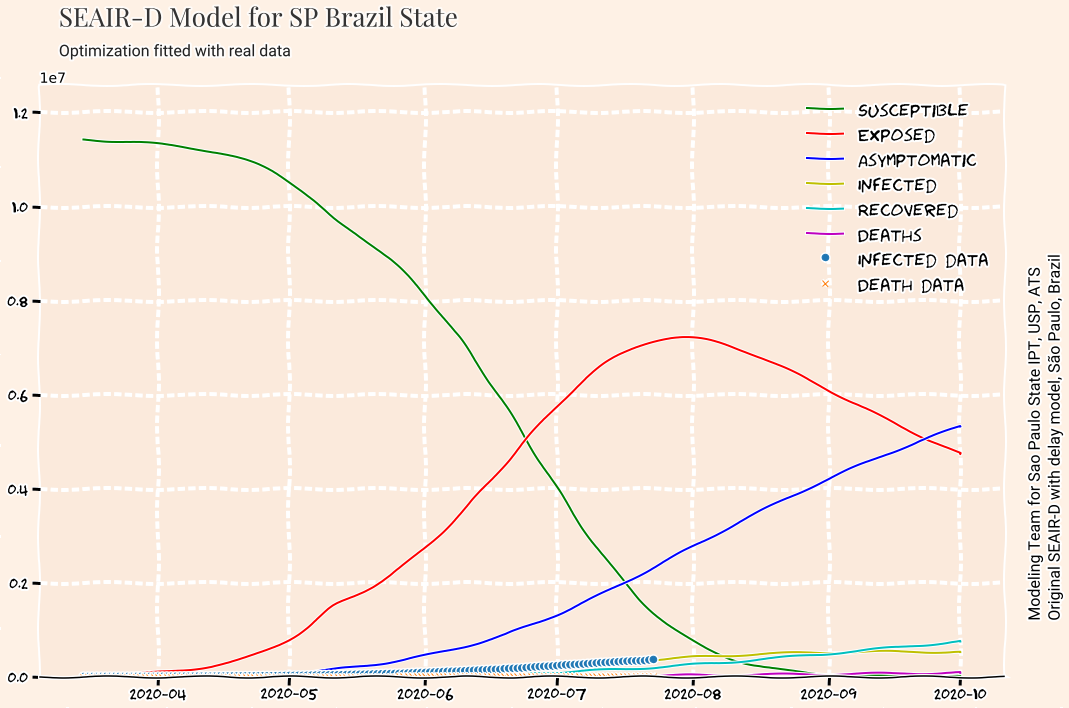

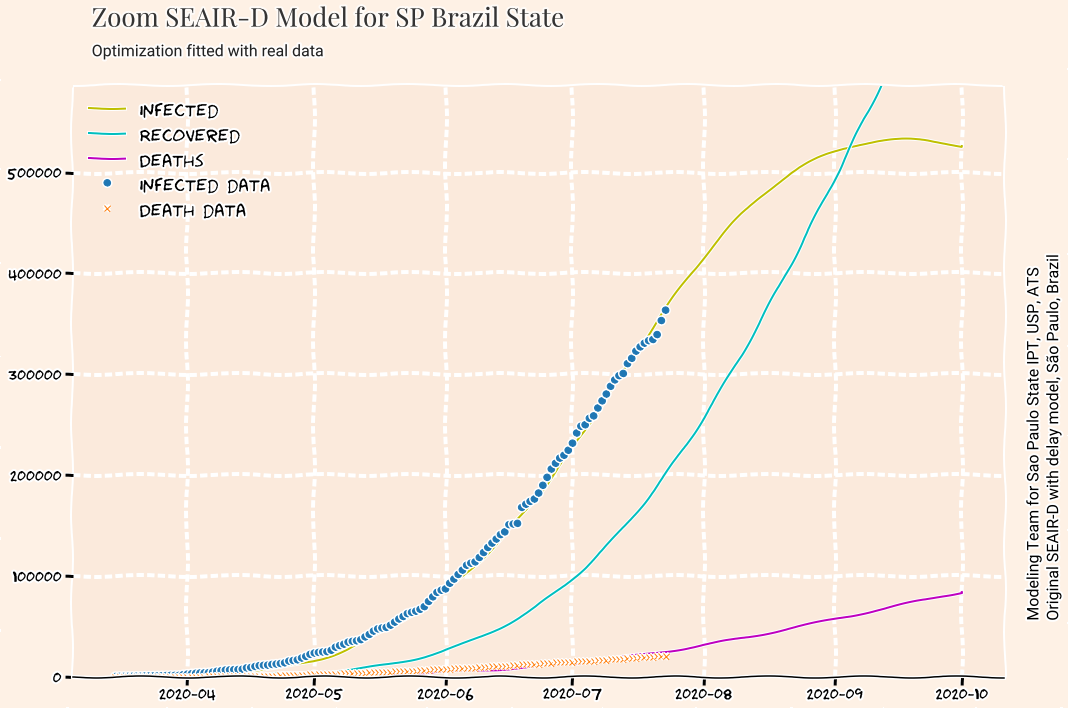

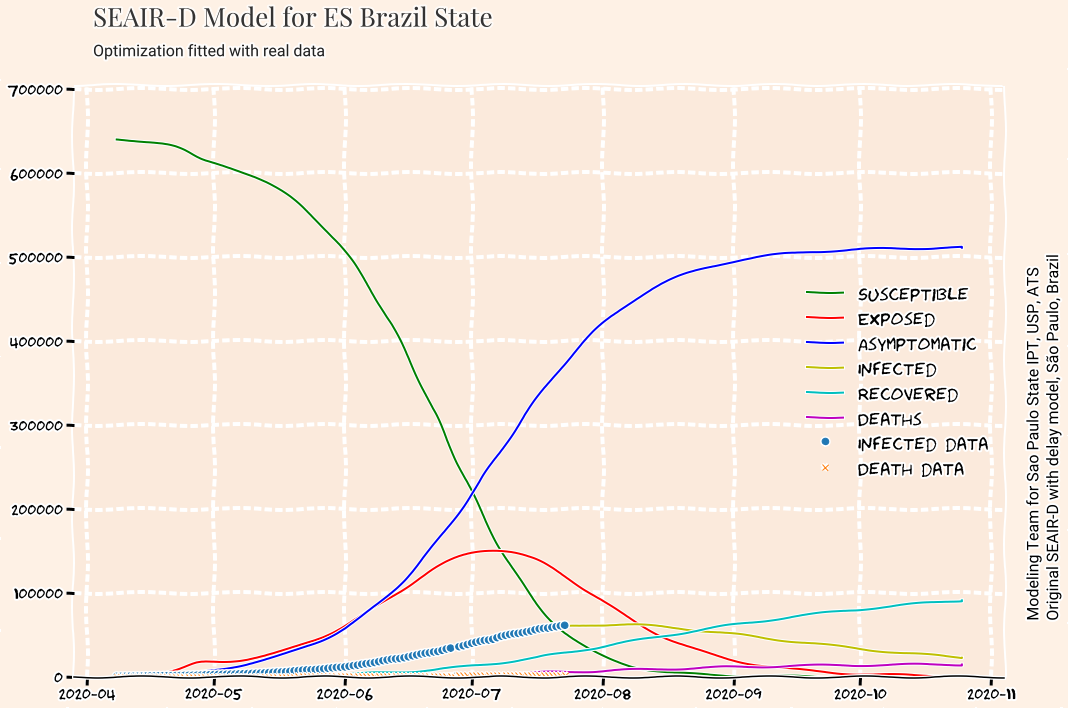

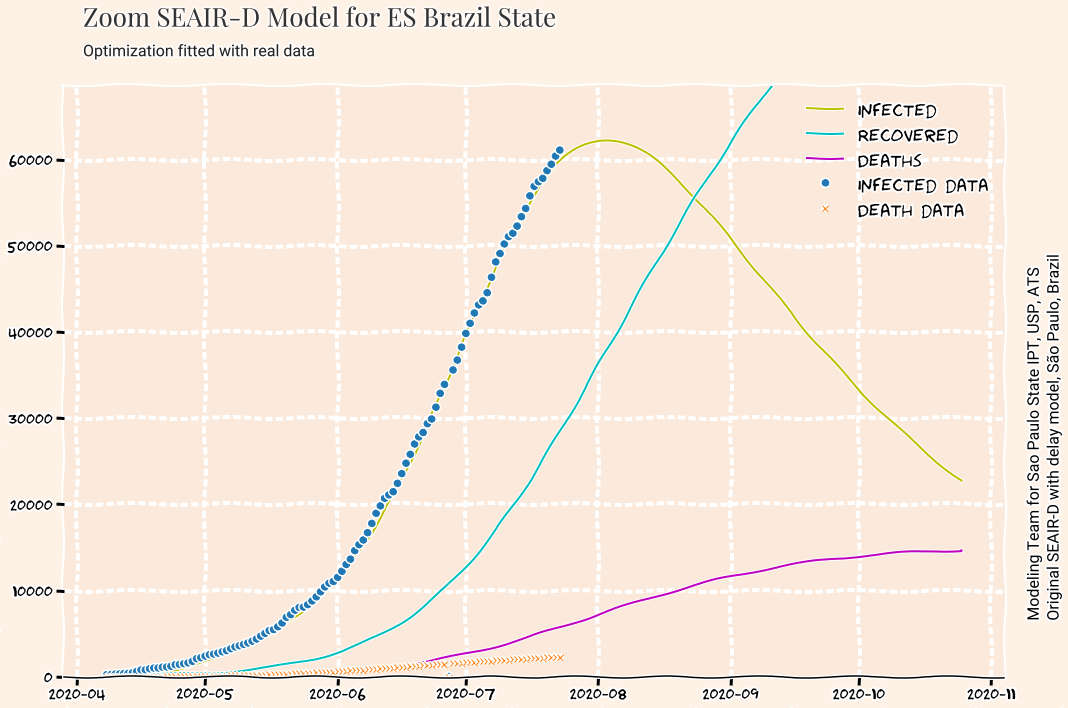

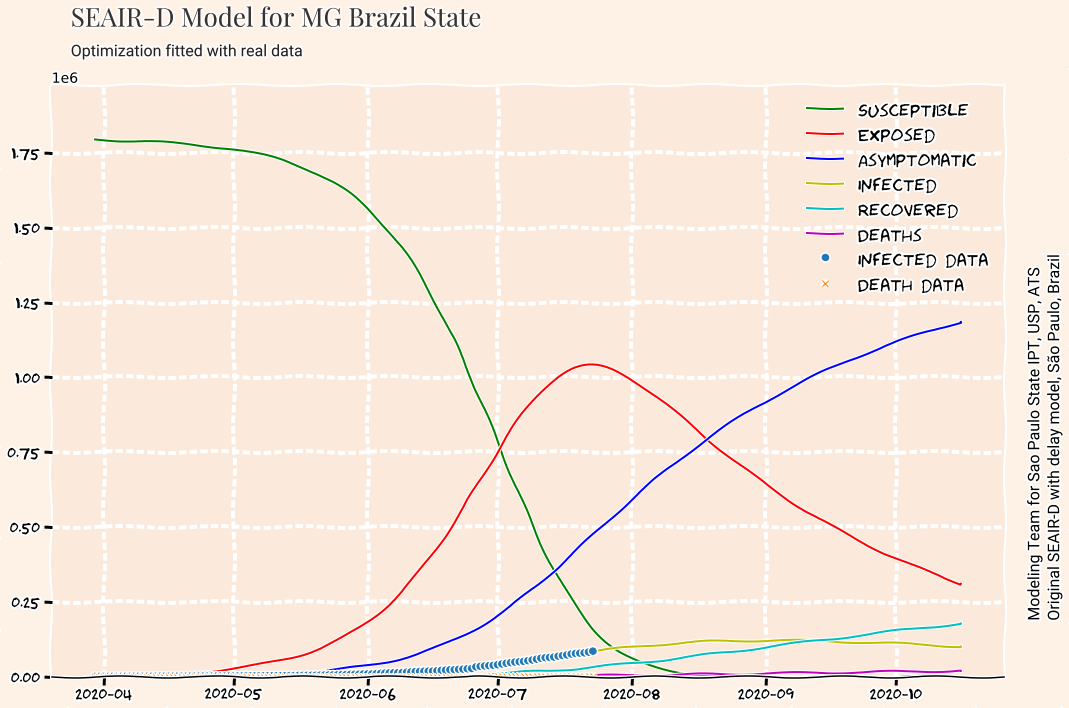

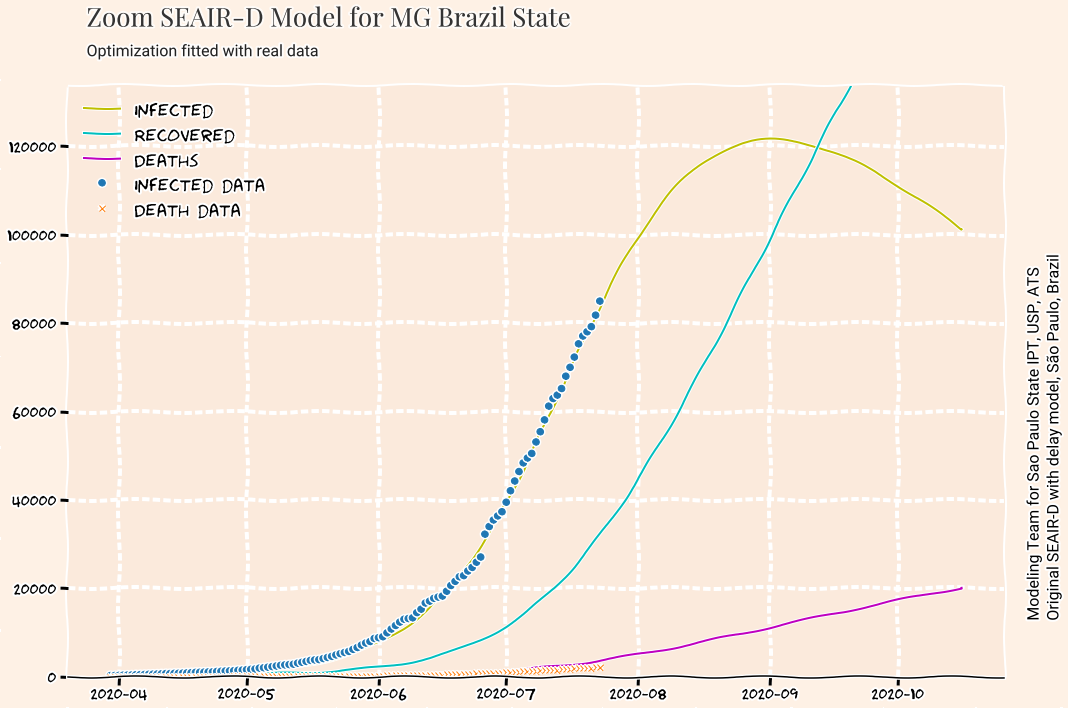

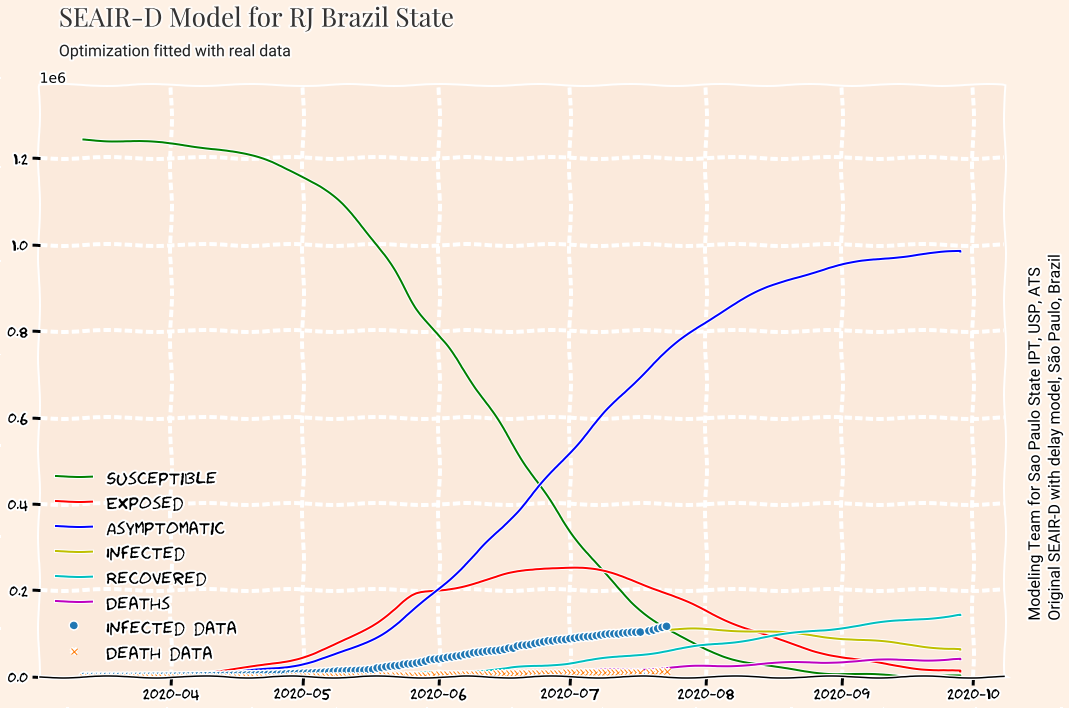

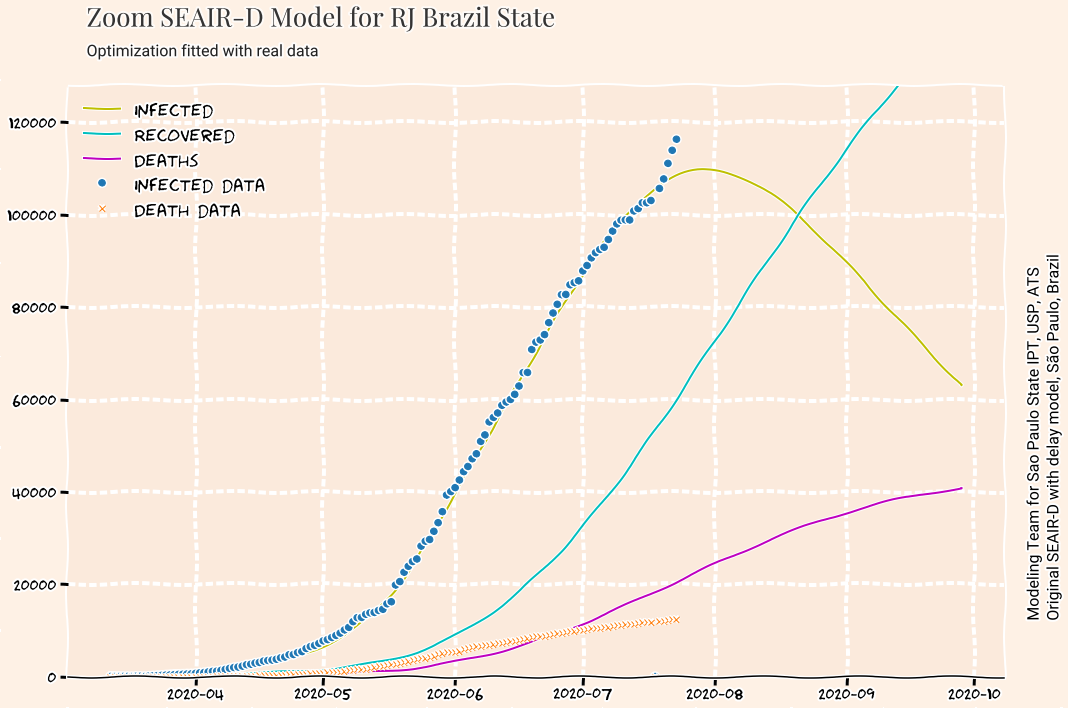

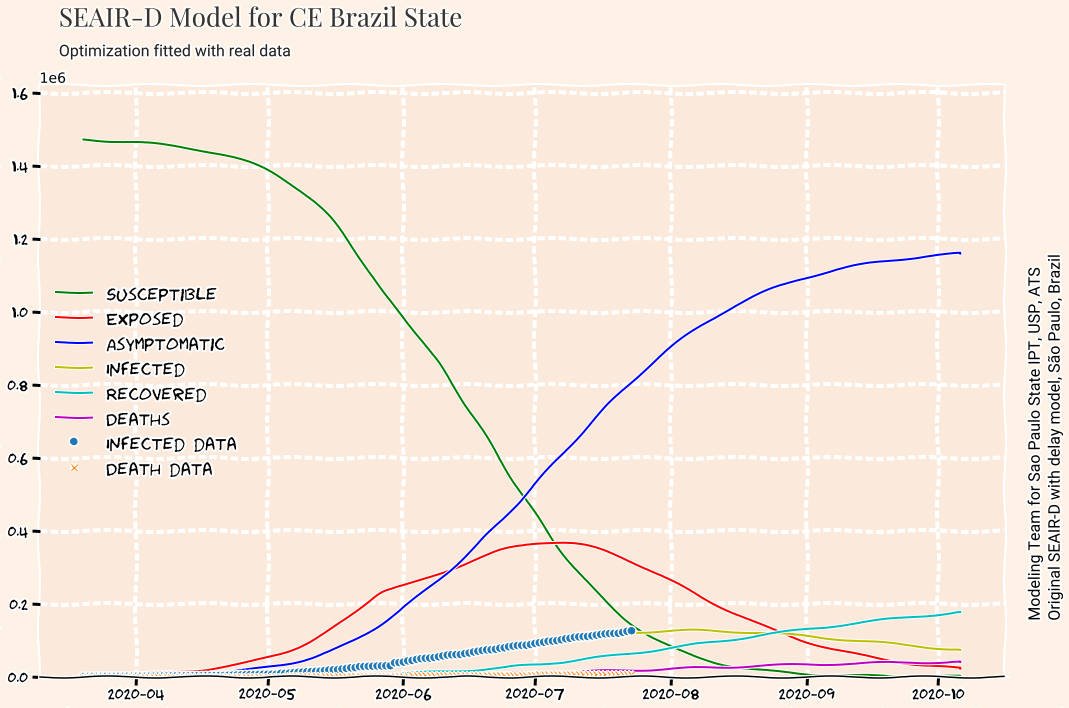

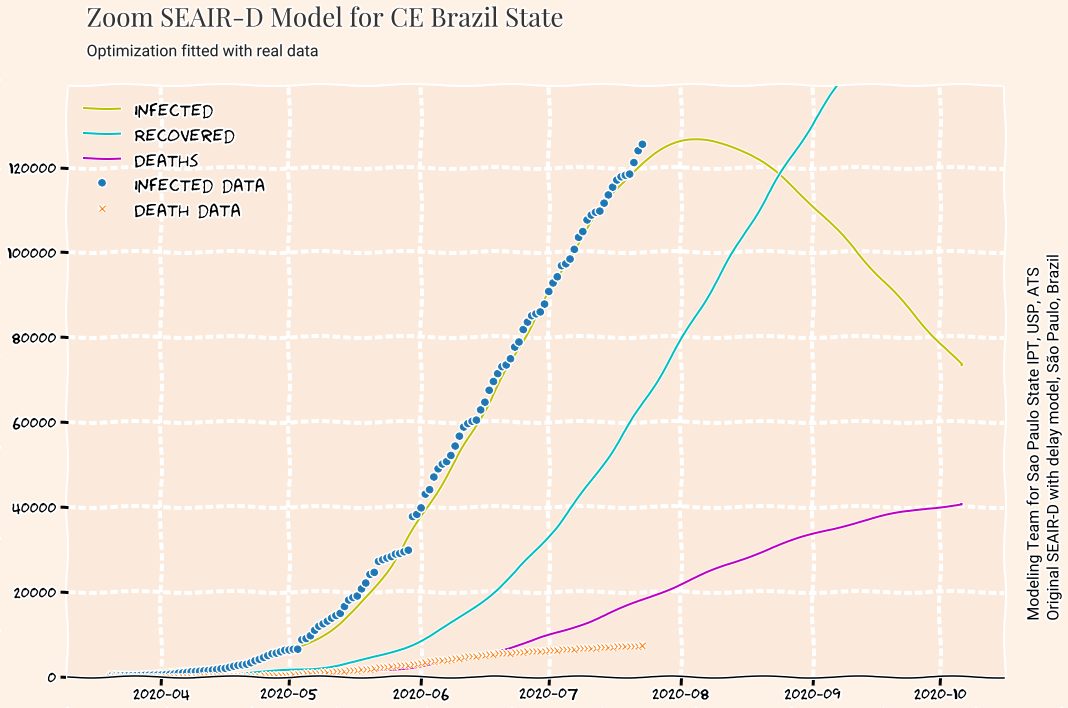

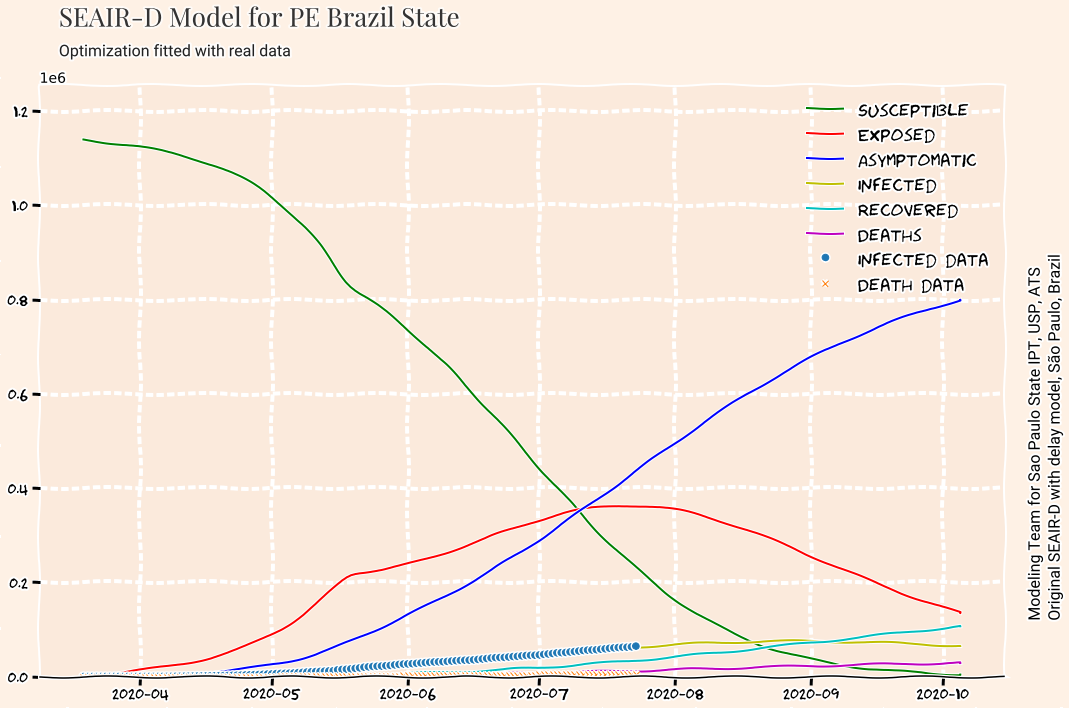

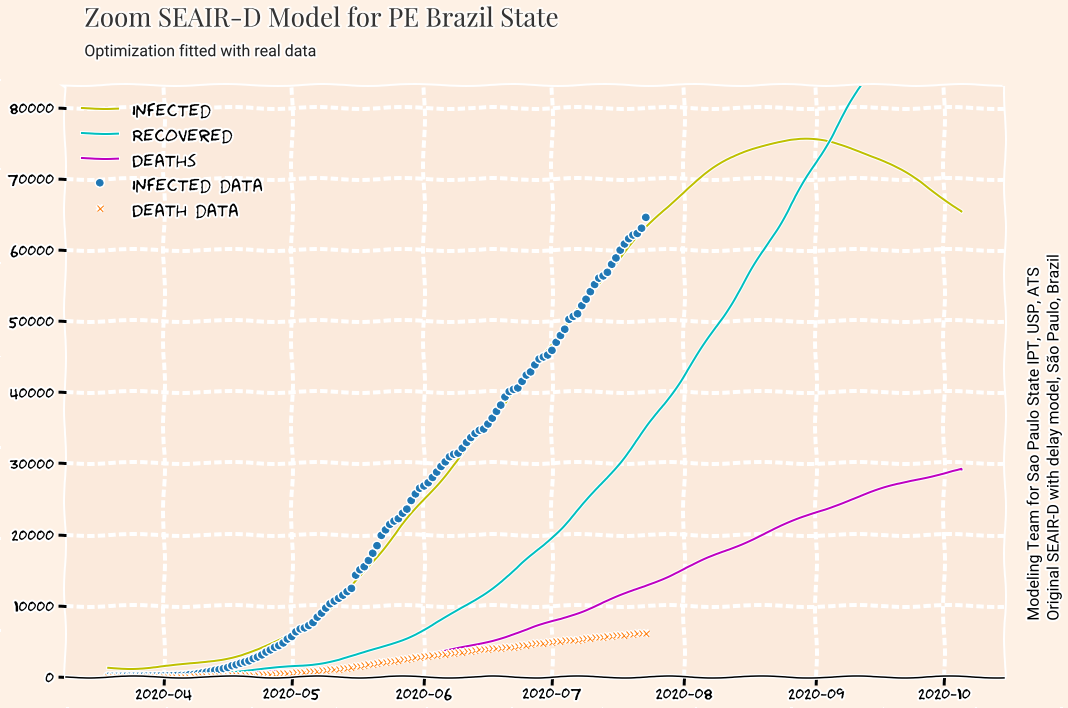

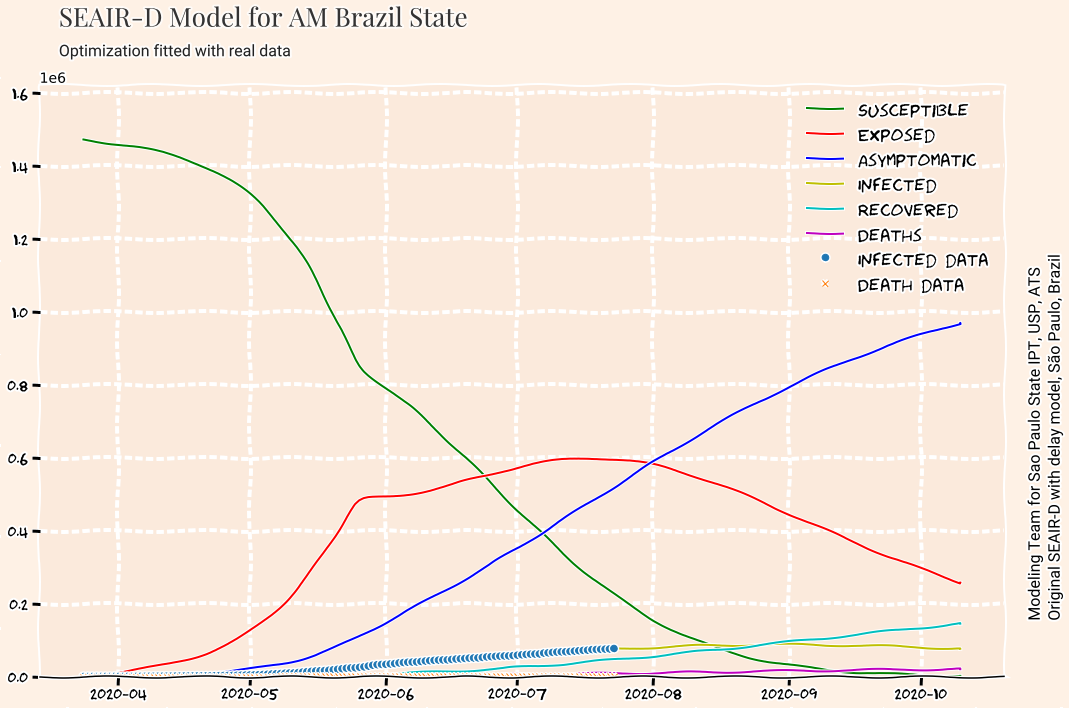

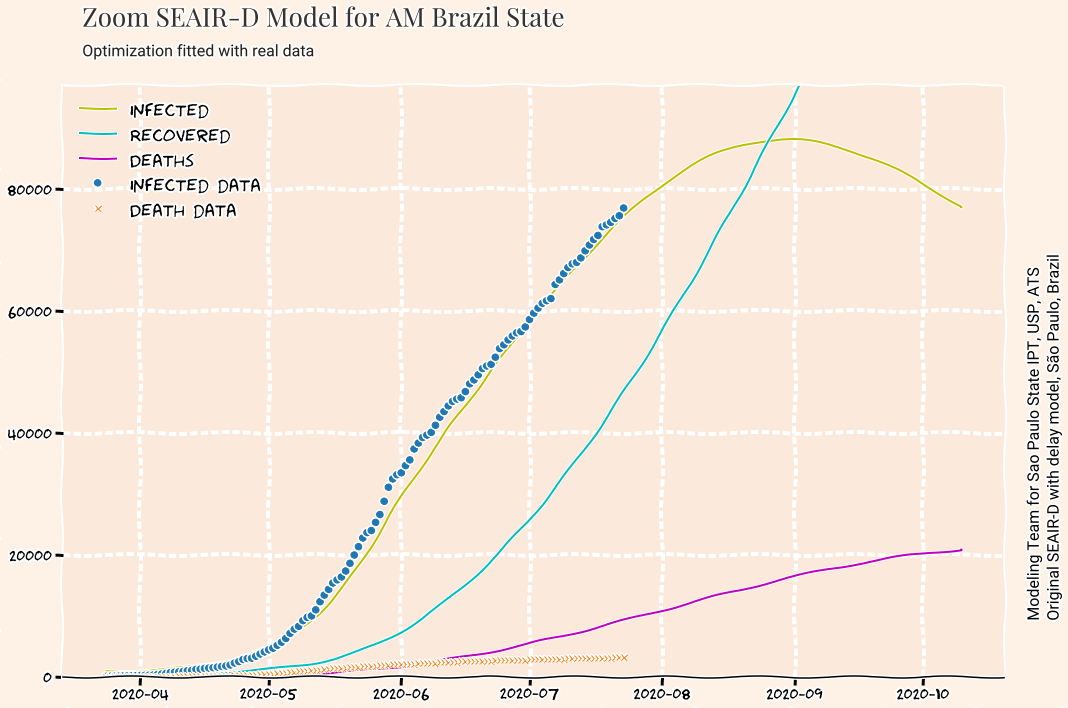

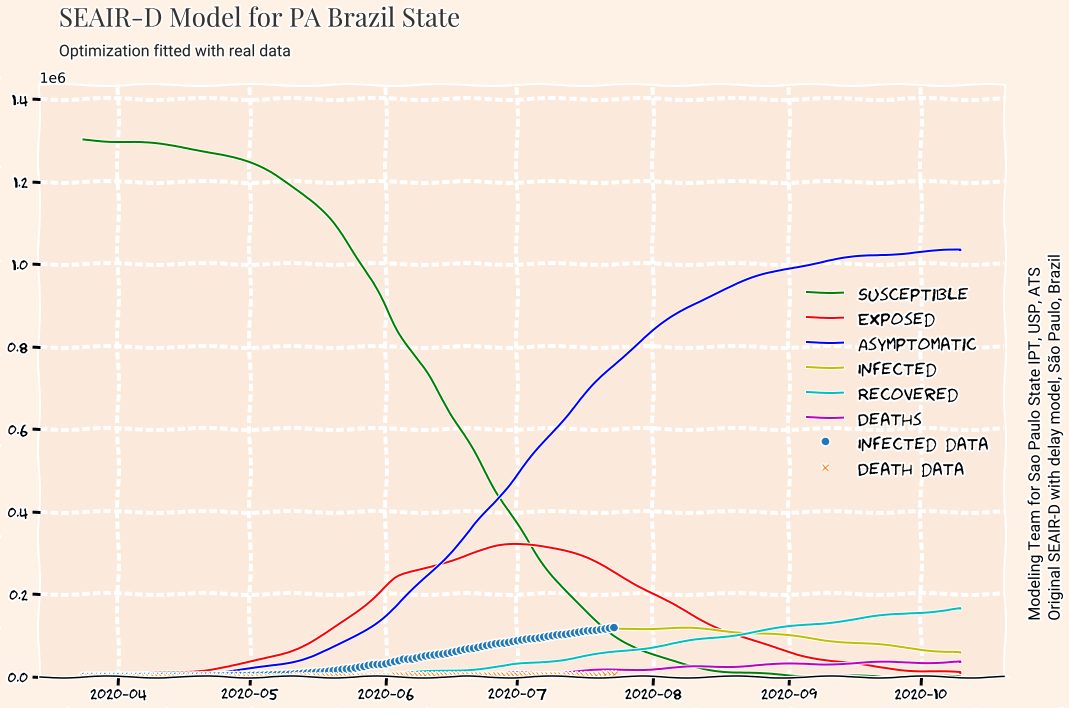

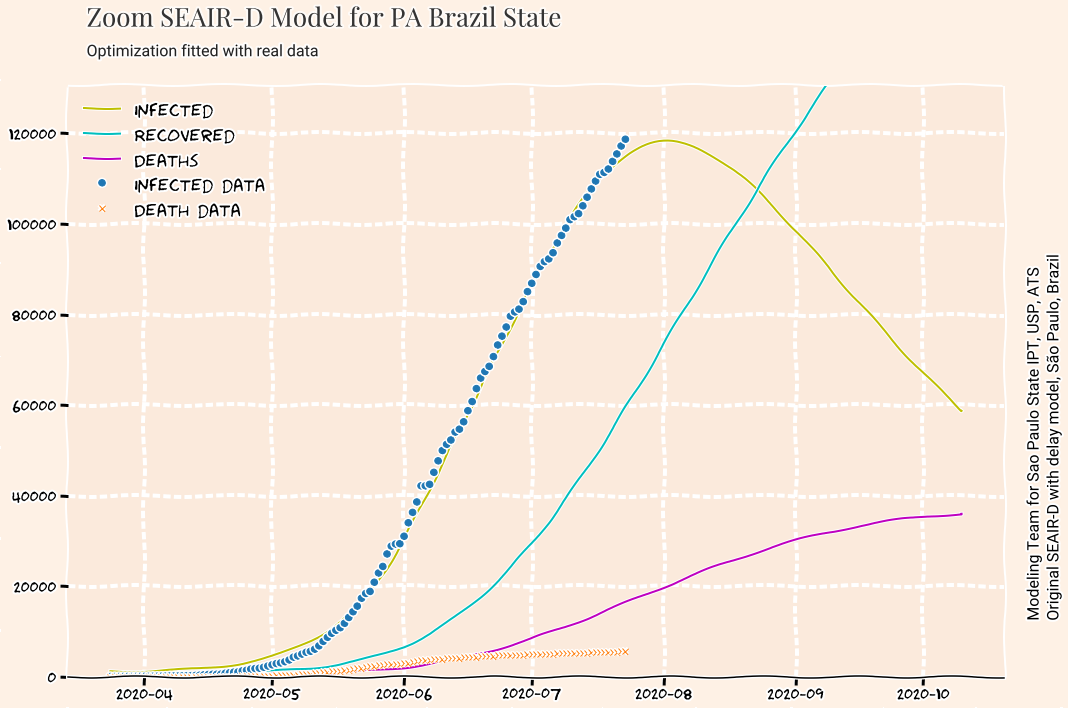

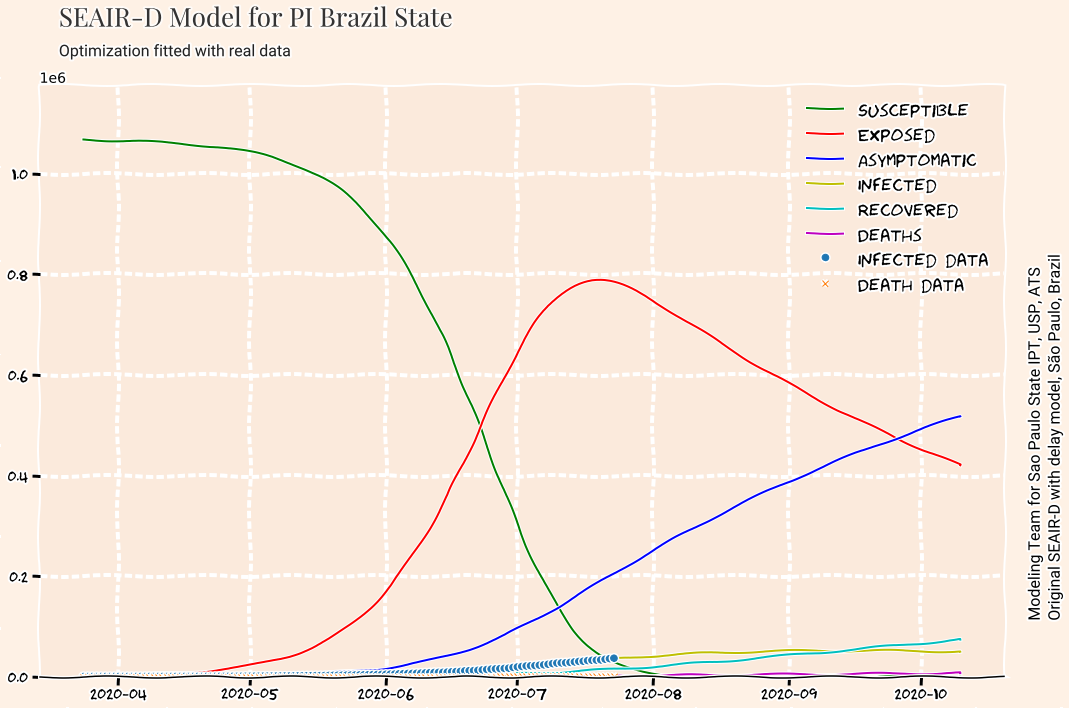

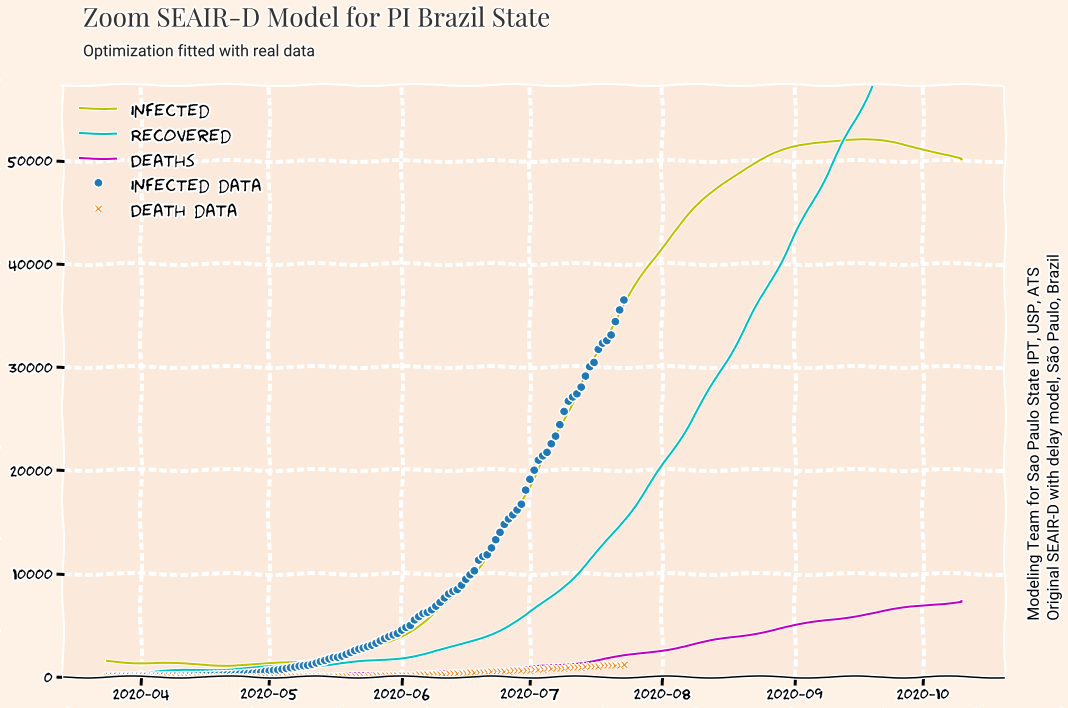

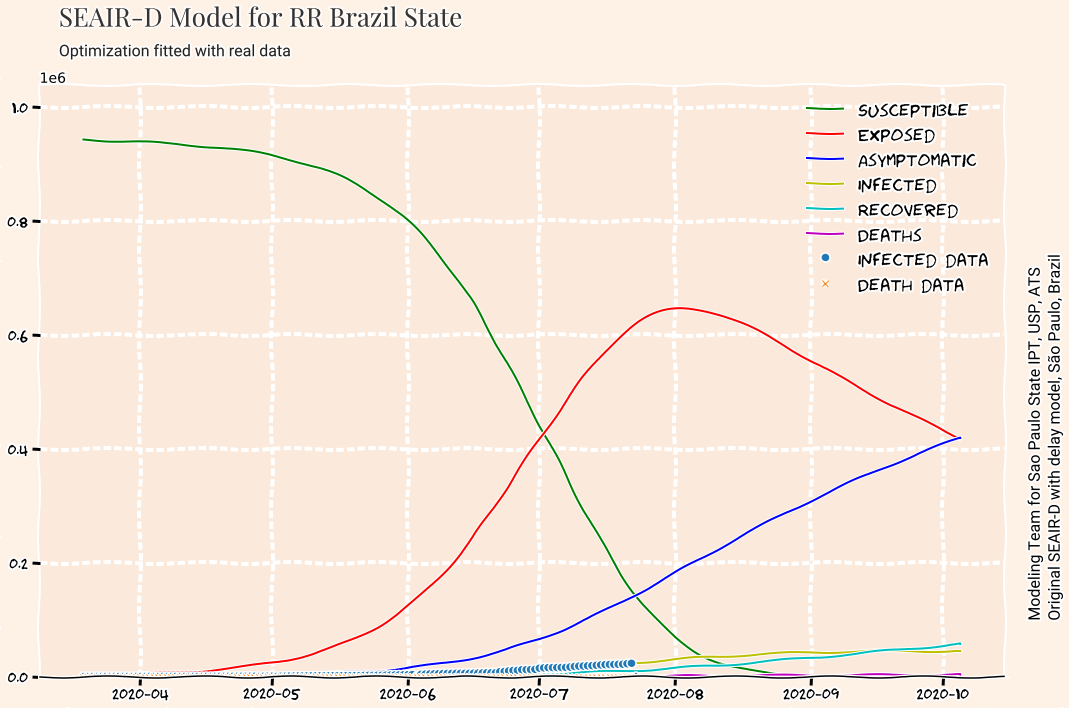

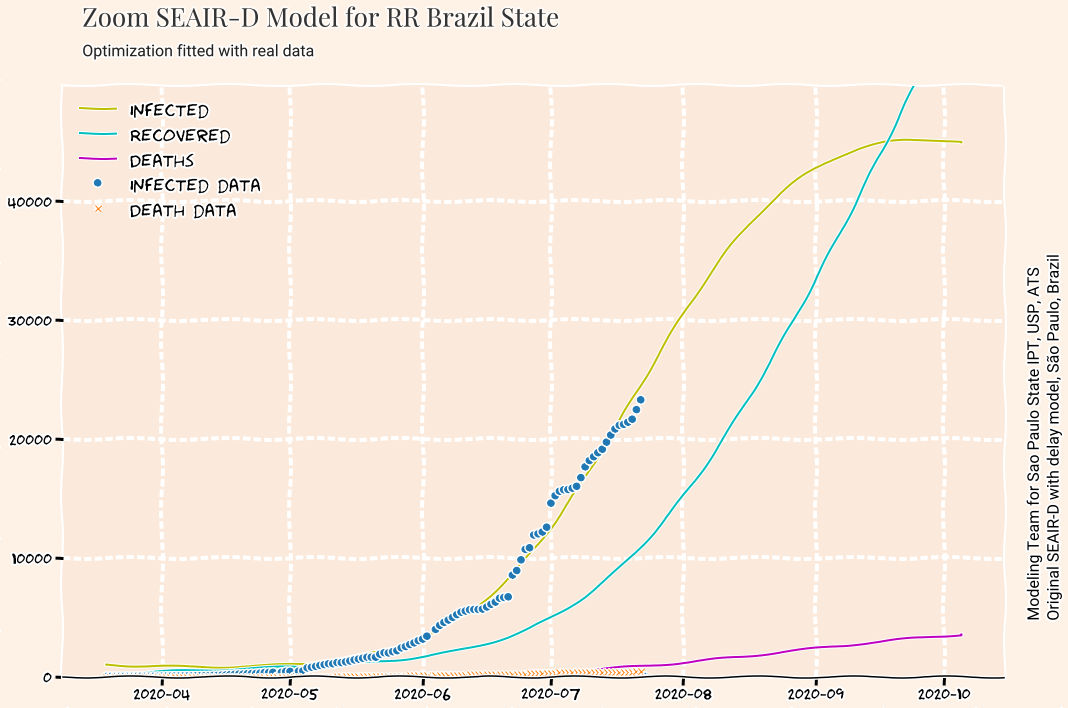

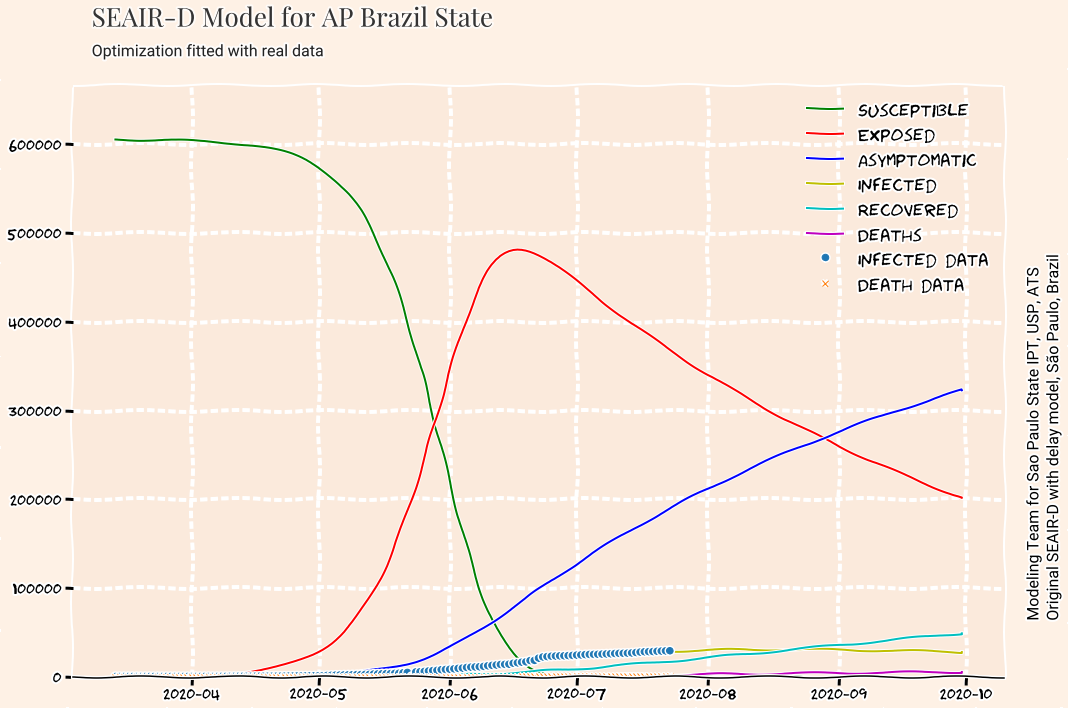

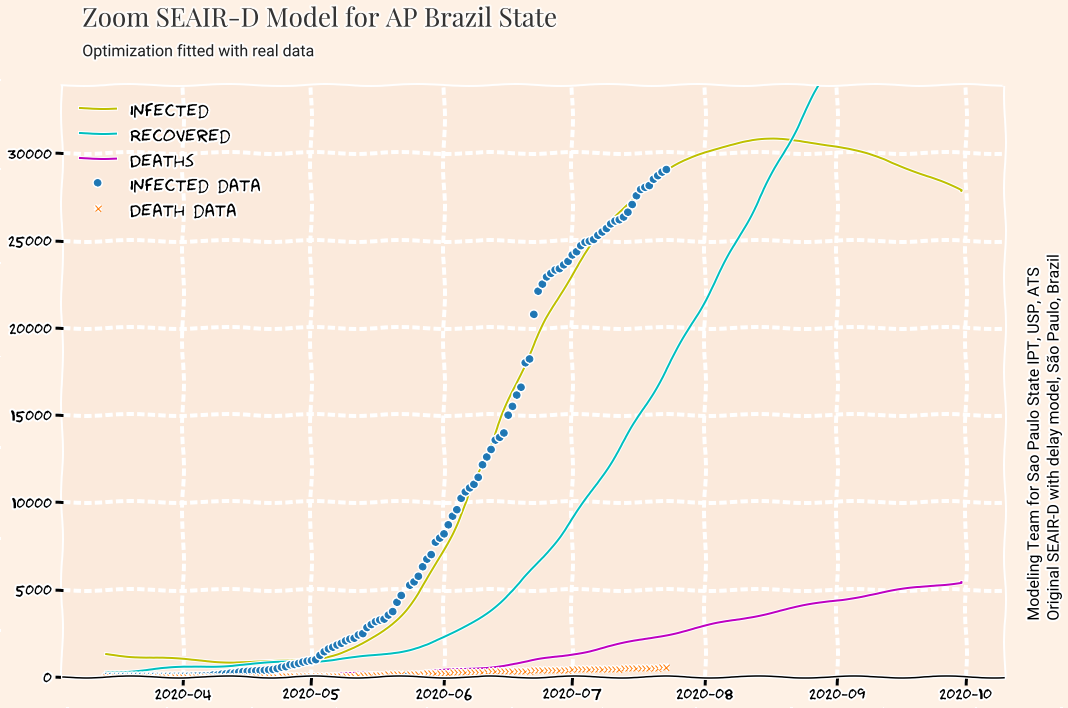

In [22]:
if allStates:
    for state in states:
        query = dfparam.query('state == "{}"'.format(state)).reset_index()
        ratio = query['RATIO'][0]
        startCase = query['START'][0]
        startdate = query['start-date'][0]
        predict_range = query['prediction-range'][0]
        
        #calcula data máxima dos gráficos
        #100 dias é usado como máximo dos cálculos da derivada das mortes
        lastDate=df.date.max()
        maxDate= lastDate + timedelta(days = 100) #"2020-08-31"
        maxDateStr = maxDate.strftime("%Y-%m-%d")

        covid_plots.covid_plots(state, states4Plot, startdate, predict_range, \
                        startCase, opt, version, show=True, ratio=ratio, maxDate=maxDateStr, model=model)
else: 
    query = dfparam.query('state == "{}"'.format(state)).reset_index()
    ratio = query['RATIO'][0]
    startdate = query['start-date'][0]
    predict_range = query['prediction-range'][0]
    startCase = query['START'][0]
    
    #calcula data máxima dos gráficos
    #100 dias é usado como máximo dos cálculos da derivada das mortes
    lastDate=df.date.max()
    maxDate= lastDate + timedelta(days = 100) #"2020-08-31"
    maxDateStr = maxDate.strftime("%Y-%m-%d")    
    
    covid_plots.covid_plots(state, states4Plot, startdate, predict_range, \
                       startCase, opt, version, show=True, ratio=ratio, maxDate=maxDateStr, model=model)